# Santander Value Prediction Challenge

## Description

According to Epsilon research, 80% of customers are more likely to do business with you if you provide personalized service. Banking is no exception.

The digitalization of everyday lives means that customers expect services to be delivered in a personalized and timely manner… and often before they´ve even realized they need the service. In their 3rd Kaggle competition, Santander Group aims to go a step beyond recognizing that there is a need to provide a customer a financial service and intends to determine the amount or value of the customer's transaction. This means anticipating customer needs in a more concrete, but also simple and personal way. With so many choices for financial services, this need is greater now than ever before.

In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.

## Evaluation

![Evaluation Metric](./images/evaluation.png)

## Importing Python Packages

In [50]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn import preprocessing

from collections import defaultdict

# Additional Configuration
pd.set_option('display.max_columns', 0)
sns.set(style="whitegrid", color_codes=True)
matplotlib.rc('axes', edgecolor='white')
matplotlib.rc('xtick', color='white')
matplotlib.rc('ytick', color='white')
%matplotlib inline

## Explorarory Data Analysis

### 1. Loading the Datasets

In [6]:
train_raw = pd.read_csv('./datasets/train.csv')
test_raw = pd.read_csv('./datasets/test.csv')

print("Training dataset shape: ", train_raw.shape)
print("Testing dataset shape: ", test_raw.shape)

Training dataset shape:  (4459, 4993)
Testing dataset shape:  (49342, 4992)


In [18]:
train_raw.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,316b978cd,d04e16aed,5d5c5ce6d,ec863cb52,11ad148bd,ea18d720e,408d86ce9,69d8b4020,b0868a049,80b14398e,ecdef52b2,c36bcacc5,151d318cd,ab0cddb90,2d6bd8275,dfdf4b580,c87722678,a8c320153,7df8788e8,a04684f1f,fa977f17b,feed9d437,645b47cde,7298ca1ef,d80abf8bc,654dd8a3b,7fc39583c,8c94b6675,e421c414e,5b91580ee,964335fdf,5a86cabd0,6cb207ac9,c1bc828da,e90ed19da,c4d38135f,968b01ca3,26b423c42,0656586a4,...,c283d4609,11114a47a,b961b0d59,103b8a033,43d70cc4d,09184c121,08c089775,572d36d31,1de239e78,d7568383a,8d7bfb911,5964f1856,6c7bf200b,b3058e9ba,108fe14ef,dcfcddf16,5fad07863,b904b8345,408021ef8,ef30f6be5,e29d22b59,a19b05919,e849e3ae0,05f11f48f,49f11e712,c959d372a,b625fe55a,f642213a6,6df033973,1834f29f5,31e434a58,e431708ff,fb42abc0d,88263a031,ab7764ead,a380d5301,46ee7f2c8,2e1287e41,23310aa6f,9dc52515a,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,1300000.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,1100000.0,0,0,0,0.0,0.0,14800000,0.0,1200000.0,0.0,0.0,0,0,0,0,0.0,4000000,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,24000000.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,...,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


In [19]:
test_raw.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,316b978cd,d04e16aed,5d5c5ce6d,ec863cb52,11ad148bd,ea18d720e,408d86ce9,69d8b4020,b0868a049,80b14398e,ecdef52b2,c36bcacc5,151d318cd,ab0cddb90,2d6bd8275,dfdf4b580,c87722678,a8c320153,7df8788e8,a04684f1f,fa977f17b,feed9d437,645b47cde,7298ca1ef,d80abf8bc,654dd8a3b,7fc39583c,8c94b6675,e421c414e,5b91580ee,964335fdf,5a86cabd0,6cb207ac9,c1bc828da,e90ed19da,c4d38135f,968b01ca3,26b423c42,0656586a4,b4ced4b7a,...,c283d4609,11114a47a,b961b0d59,103b8a033,43d70cc4d,09184c121,08c089775,572d36d31,1de239e78,d7568383a,8d7bfb911,5964f1856,6c7bf200b,b3058e9ba,108fe14ef,dcfcddf16,5fad07863,b904b8345,408021ef8,ef30f6be5,e29d22b59,a19b05919,e849e3ae0,05f11f48f,49f11e712,c959d372a,b625fe55a,f642213a6,6df033973,1834f29f5,31e434a58,e431708ff,fb42abc0d,88263a031,ab7764ead,a380d5301,46ee7f2c8,2e1287e41,23310aa6f,9dc52515a,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.528249e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.175880e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3360000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,20884000.0,0.0,0.0,0.0,0.0,0.0,36252000.0,0.0,20000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.

### 2. Displaying Dataset Information

In [24]:
dtype_df = train_raw.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


#### Columns with Zero Values Proportion

In [25]:
zero_values = train_raw.apply(lambda x: sum(x == 0)*(100/4993))

In [38]:
zero_values.sort_values(ascending=True)

ID            0.000000
target        0.000000
c5a231d81    57.961146
0ff32eb98    57.961146
91f701ba2    58.061286
c47340d97    58.161426
adb64ff71    58.321650
0572565c2    58.321650
f190486d6    58.381734
5c6487af1    58.481875
e176a204a    58.561987
6619d81fc    58.602043
70feb1494    58.622071
23310aa6f    58.622071
190db8488    58.702183
1db387535    58.762267
491b9ee45    58.802323
66ace2992    58.842379
9fd594eec    58.862407
fc99f9426    58.902463
58e2e02e6    59.002604
703885424    59.002604
eeb9cd3aa    59.022632
1931ccfdd    59.082716
324921c7b    59.182856
1702b5bf0    59.262968
fb0f5dbfe    59.363108
f74e8f13d    59.383136
20aa07010    59.383136
26fc93eb7    59.423192
               ...    
20854f8bf    89.305027
86f843927    89.305027
ac2e428a9    89.305027
5ee7de0be    89.305027
be10df47c    89.305027
cb2cb460c    89.305027
316423a21    89.305027
2e52b0c6a    89.305027
ecd16fc60    89.305027
d87dcac58    89.305027
9a5ff8c23    89.305027
ae846f332    89.305027
ae28689a2  

#### Columns with Constant Value

In [56]:
unique_df = train_raw.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

#### Removing Columns with Constant Values (Single Unique Value)

In [63]:
train_df = train_raw.drop(constant_df.col_name.tolist(), axis=1)
train_df.shape

(4459, 4737)

### 3. Target Distribution

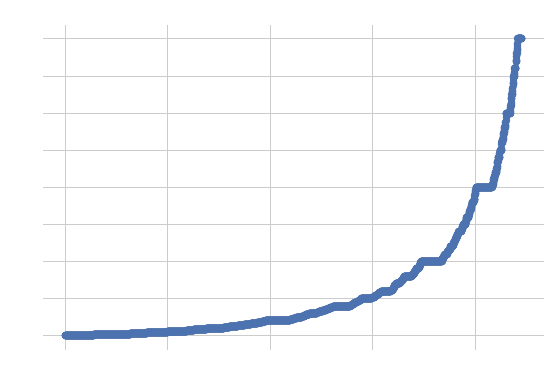

In [52]:
plt.figure(figsize=(9,6))
plt.scatter(range(train_raw.shape[0]), np.sort(train_raw['target'].values))
plt.xlabel('index', fontsize=12, color='#FFFFFF')
plt.ylabel('Target', fontsize=12, color='#FFFFFF')
plt.title("Target Distribution", fontsize=14, color='#FFFFFF')
plt.show()

#### Target Histogram

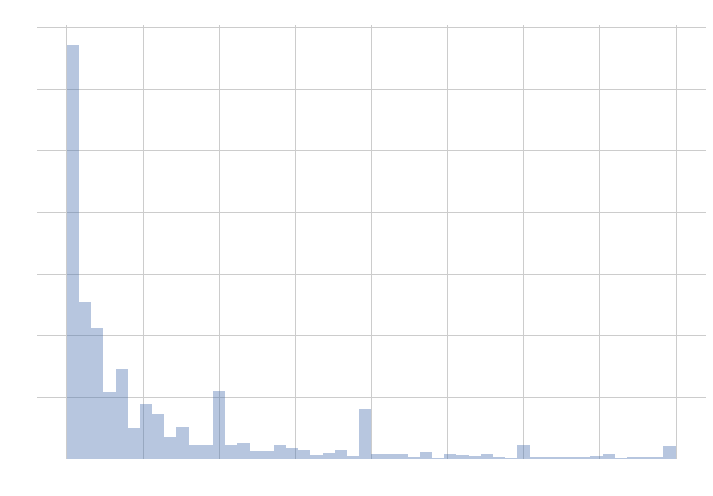

In [54]:
plt.figure(figsize=(12,8))
sns.distplot(train_raw["target"].values, bins=50, kde=False)
plt.xlabel('Target', fontsize=12, color='white')
plt.title("Target Histogram", fontsize=14, color='white')
plt.show()

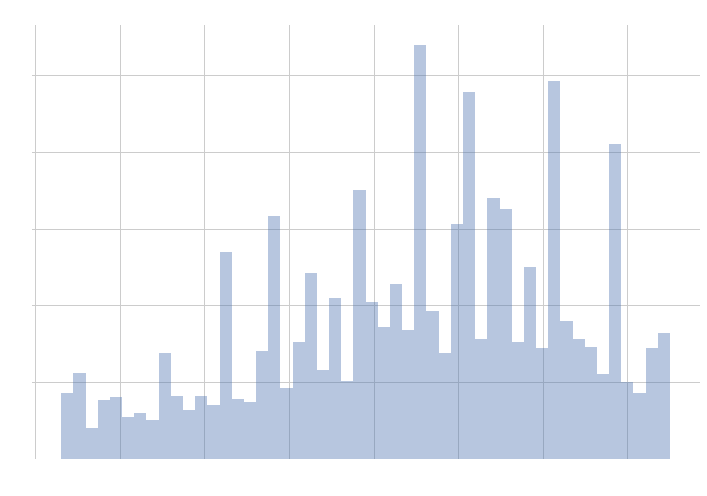

In [55]:
plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_raw["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12, color='white')
plt.title("Target Histogram", fontsize=14, color='white')
plt.show()

### 4. Correlation Analysis

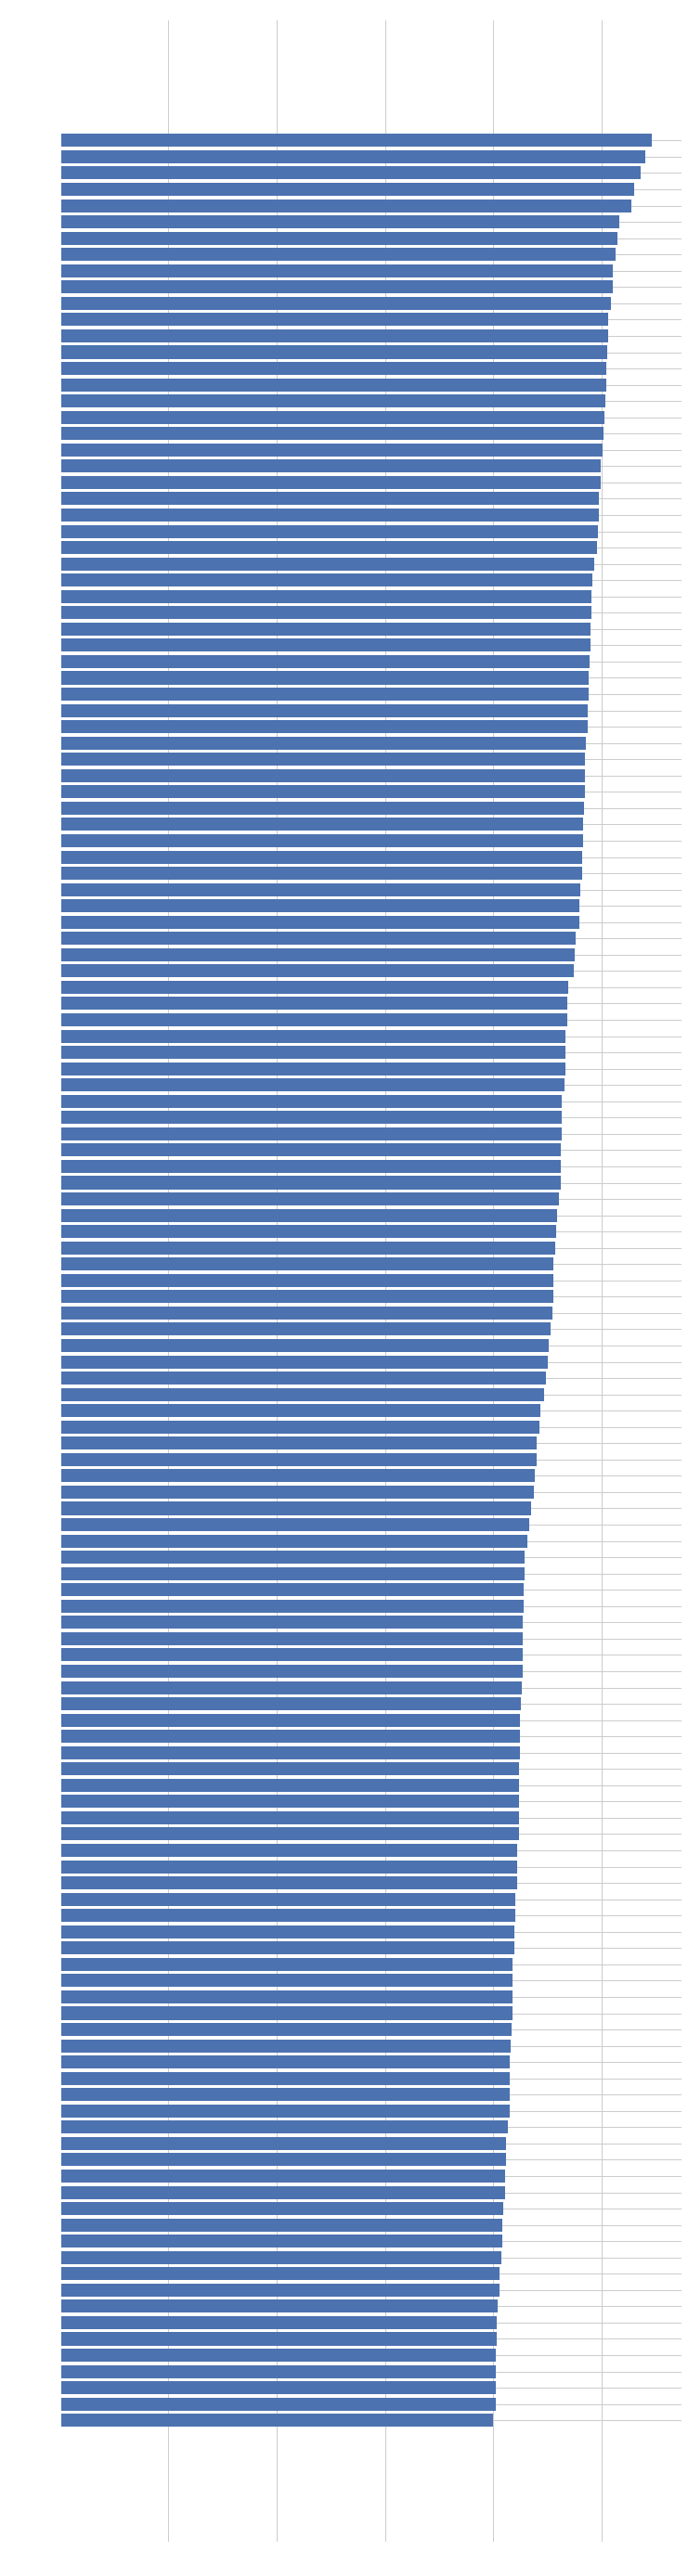

In [68]:
labels = [x for x in train_df.columns if x not in ['ID', 'target']]
values = [np.corrcoef(train_df[x].values, train_df['target'].values)[0,1] for x in train_df.columns if x not in ['ID', 'target']]

corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

# Generating Bar Plot For Correlation > 0.2
corr_df = corr_df[(corr_df['corr_values']>0.2) | (corr_df['corr_values']<-0.2)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,50))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient", color='white')
ax.set_title("Correlation coefficient of the variables", color='white')

plt.show()

#### Correlation Heat Map

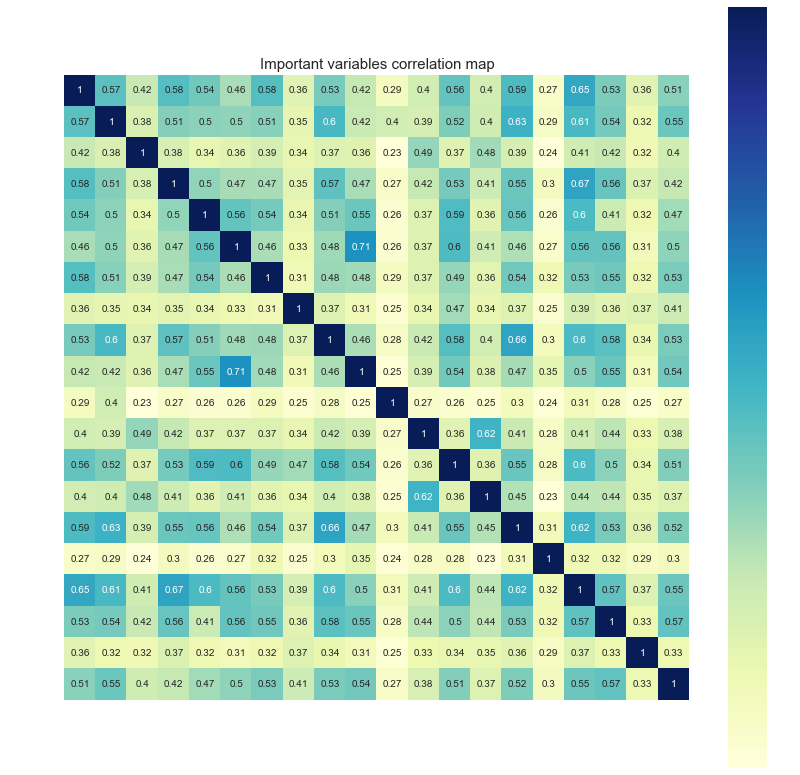

In [70]:
cols_to_use = corr_df[(corr_df['corr_values']>0.25) | (corr_df['corr_values']<-0.25)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='pearson')
f, ax = plt.subplots(figsize=(14, 14))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()